In [1]:
from __future__ import annotations

import json
import os
import re
import warnings
from datetime import datetime
from typing import Any, Dict, List, Optional, Tuple

import duckdb
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import osmnx as ox
import pandas as pd
import shapely
from datasets import load_dataset
from dateutil import rrule
from keplergl import KeplerGl
from shapely.errors import GEOSException
from shapely.geometry import LineString, MultiPoint, MultiPolygon, Point, Polygon
from shapely.geometry.base import BaseGeometry
from shapely.ops import polygonize, unary_union
from shapely.prepared import prep
from shapely.strtree import STRtree
from shapely.validation import make_valid
from sklearn import svm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler

/home/tomf/.cache/pypoetry/virtualenvs/mobile-coverage-V9QxNgPA-py3.12/lib/python3.12/site-packages/keplergl/keplergl.py:13: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_string


In [2]:
START_DATE = datetime(2025, 3, 1)
END_DATE = datetime(2025, 6, 30)

# Iterate through every month from START_DATE to END_DATE
all_months = list(rrule.rrule(rrule.MONTHLY, dtstart=START_DATE, until=END_DATE))

# Format as ISO dates
all_months = [x.strftime("%Y-%m-%d") for x in all_months]

In [3]:
# Load dataset from Hugging Face

# ds = load_dataset("joefee/cell-service-data")

# first 100k rows of the default split (often "train")
# ds = load_dataset("joefee/cell-service-data", split="train[:100000]")

ds = load_dataset(
    "joefee/cell-service-data",
    data_files={
        "train": [
            "np_extract_part_1.csv", "np_extract_part_2.csv",
            "np_extract_part_3.csv", "np_extract_part_4.csv",
            "np_extract_part_5.csv", "np_extract_part_6.csv",
            # "np_extract_part_7.csv", "np_extract_part_8.csv",
            # "np_extract_part_9.csv",
        ]
    },
)


HTTP Error 504 thrown while requesting HEAD https://huggingface.co/datasets/joefee/cell-service-data/resolve/6cfbf58a97bf3f527ee9109a3bead92e7c31511c/.huggingface.yaml
Retrying in 1s [Retry 1/5].


In [4]:
# Convert to pandas dataframe
df = ds['train'].to_pandas()

In [5]:
# Browse the dataset
df

,timestamp,unique_cell,measurement_type_name,in_outdoor_state,value,latitude,longitude,signal_level
0,2025-03-01 15:48:22.455,d66c4660d6f77433b503d2e0159ce7053bdd76dc,None,None,-91.0,52.941137,-1.180972,-112.207920
1,2025-03-01 03:15:47.436,bb8abb3cfc1d2eb47edba5f216a0078d829575f2,None,Probably Indoor,-9.0,52.756933,-1.517308,-120.000000
2,2025-03-01 12:26:07.000,3fb387a3995398fc5602cc0e431ce935044c594e,None,Probably Outdoor,-108.0,52.770351,-1.208205,-108.719592
3,2025-03-01 09:49:03.000,e662f0bf857466dafbb8da554abfec2e86335deb,None,Surely Outdoor,46.8,52.644803,-1.189687,-103.070615
4,2025-03-01 00:56:44.711,0fed16bc81fbd0ef53e6071cf9fd8449d810fdfc,None,Surely Indoor,-7.0,52.887214,-1.534917,-96.205530
...,...,...,...,...,...,...,...,...
21539100,2025-05-23 14:35:36.419,c0e3e8685938444da0c7e2f19f2c7a4ce1fefa0a,None,Probably Outdoor,8.0,53.054429,-1.203648,-112.072660
21539101,2025-05-23 08:19:25.710,e595e5aef99a1fffa05d24fe388406e6ee014e1c,None,None,-12.0,53.043867,-1.379464,NaN
21539102,2025-05-23 14:46:34.109,b589358c1bb4ab7d3d646450920bccecf0fe08c2,None,Probably Indoor,164.0,52.967187,-1.121708,-107.690839
21539103,2025-05-23 12:02:29.927,062554e4b77b5f4f275ced1a80d3a6510246665e,None,Probably Indoor,-110.0,53.075805,-1.569441,-117.110384


In [6]:
# Bin this into signal level categories
# UK Ofcom Reference URL: 
# https://www.ofcom.org.uk/siteassets/resources/documents/phones-telecoms-and-internet/comparing-service-quality/2025/map-your-mobile-2025-threshold-methodology.pdf
df["signal_level_category"] = pd.cut(
    df["signal_level"],
    bins=[-np.inf, -105, -95, -82, -74, np.inf],
    labels=["1. Very Weak", "2. Weak", "3. Moderate", "4. Strong", "5. Very Strong"]
)

In [7]:
# Identify cells with sufficient data points
# Cells must also have signal_level_category value
min_points_required = 30

sufficient_data_cells = duckdb.query(f"""
WITH monthly_count AS (
    SELECT
        unique_cell, 
        date_trunc('month', CAST(timestamp AS timestamp)) as month, 
        COUNT(*) as count
    FROM df
    WHERE signal_level IS NOT NULL
    GROUP BY unique_cell, month HAVING COUNT(*) >= {30}
)
SELECT unique_cell 
FROM monthly_count 
GROUP BY unique_cell
HAVING COUNT(DISTINCT month) = {len(all_months)}
""").to_df()['unique_cell'].tolist()

In [8]:
# Identify all unique cells
# remove outlier cells
outlier_cells = ["4dc7c9ec434ed06502767136789763ec11d2c4b7"]
sufficient_data_cells = [cell for cell in sufficient_data_cells if cell not in outlier_cells]

print(f"Number of cells with sufficient data: {len(sufficient_data_cells)}")
print(f"Total number of cells: {df['unique_cell'].nunique()}")

Number of cells with sufficient data: 0
Total number of cells: 31843


In [9]:
def generate_convex_hull_geom(df, quantile:float=0.95) -> BaseGeometry:
    """
    Generate a valid convex hull MultiPolygon from input DataFrame.
    Converts input longitude/latitude columns to float type if they are not already.

    Args:
        df (pd.DataFrame): DataFrame with 'longitude' and 'latitude' columns.
        **args: Currently unused, present for API consistency.
    Returns:
        BaseGeometry: Shapely geometry object representing the convex hull, or None if unsuccessful.
    """

    # Construct a convex hull with shapely using train_df
    points_train = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]

    # Find center of mass among these points
    multipoint = MultiPoint(points_train)
    center_of_mass = multipoint.centroid

    # For each point, calculate distance to center of mass
    distances = [point.distance(center_of_mass) for point in points_train]
    
    # Find the 95% percentile distance
    threshold_distance = pd.Series(distances).quantile(quantile)

    # Filter points to only those within the threshold distance
    filtered_points = [point for point, distance in zip(points_train, distances) if distance <= threshold_distance]

    # Create new multipoint from filtered points
    multipoint_filtered = MultiPoint(filtered_points)
    
    # Calculate the convex hull
    convex_hull = multipoint_filtered.convex_hull

    if convex_hull.is_valid:
        return convex_hull
    else:
        print("Warning: Convex hull is invalid.")
        return None

In [10]:
def generate_svm_boundary_geom(df, **args) -> BaseGeometry:
    """
    Generate a valid MultiPolygon with true cut-out holes from One-Class SVM boundary.
    Converts input longitude/latitude columns to float type if they are not already.

    Args:
        df (pd.DataFrame): DataFrame with 'longitude' and 'latitude' columns.
                        These columns can contain numbers or Decimal objects.
        **args: Keyword arguments passed directly to svm.OneClassSVM.

    Returns:
        BaseGeometry: A valid MultiPolygon geometry representing the SVM boundary,
                      or None if the boundary could not be created.
    """

    if not isinstance(df, pd.DataFrame) or not all(col in df.columns for col in ['longitude', 'latitude']):
        print("Error: Input df must be a pandas DataFrame with 'longitude' and 'latitude' columns.")
        return None

    if len(df) < 2:
        print("Warning: Need at least 2 data points for SVM.")
        return None

    # --- Convert coordinate columns to float type ---
    # This resolves the Decimal vs float TypeError
    try:
        df_copy = df.copy() # Work on a copy to avoid modifying the original DataFrame
        df_copy['longitude'] = df_copy['longitude'].astype(float)
        df_copy['latitude'] = df_copy['latitude'].astype(float)
        coords = df_copy[['longitude', 'latitude']].values
    except (TypeError, ValueError) as e:
        print(f"Error converting coordinate columns to float: {e}")
        return None

    # --- 1. Train the SVM ---
    try:
        clf = svm.OneClassSVM(**args)
        clf.fit(coords)
    except Exception as e:
        print(f"Error during SVM training: {e}")
        return None

    # --- 2. Create mesh grid for contouring ---
    # Now calculations will use standard floats
    x_min, x_max = coords[:, 0].min(), coords[:, 0].max()
    y_min, y_max = coords[:, 1].min(), coords[:, 1].max()

    x_range = x_max - x_min
    y_range = y_max - y_min
    x_margin = x_range * 1 if x_range > 1e-9 else 0.1
    y_margin = y_range * 1 if y_range > 1e-9 else 0.1

    x_min -= x_margin
    x_max += x_margin
    y_min -= y_margin
    y_max += y_margin

    resolution = 500
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution),
                        np.linspace(y_min, y_max, resolution))
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    try:
        Z = clf.decision_function(grid_points).reshape(xx.shape)
    except Exception as e:
        print(f"Error during SVM decision function evaluation: {e}")
        return None

    # --- 3. Extract contour lines at level 0 (the boundary) ---
    fig, ax = plt.subplots()
    try:
        cs = ax.contour(xx, yy, Z, levels=[0])
    except Exception as e:
        print(f"Error during contour generation: {e}")
        plt.close(fig)
        return None
    plt.close(fig)

    if not cs.allsegs or not cs.allsegs[0]:
        print("Warning: No contour lines found at level 0.")
        return None

    segments = cs.allsegs[0]
    lines = [LineString(seg) for seg in segments if len(seg) >= 2]

    if not lines:
        print("Warning: No valid LineStrings created from contour segments.")
        return None

    # --- 4. Polygonize the lines ---
    try:
        all_polygons = list(polygonize(lines))
    except Exception as e:
        print(f"Error during polygonization: {e}")
        return None

    if not all_polygons:
        print("Warning: Polygonization did not yield any polygons.")
        return None

    # --- 5. Classify polygons and perform unary union ---
    positive_polygons = []
    for p in all_polygons:
        if p.is_valid and p.area > 1e-9:
            rep_point = p.representative_point()
            try:
                decision_val = clf.decision_function([[rep_point.x, rep_point.y]])[0]
                if decision_val >= 0:
                    # Ensure the polygon added is valid - unary_union can struggle with invalid inputs
                    if p.is_valid:
                        positive_polygons.append(p)
                    else:
                    # Attempt to buffer by 0 to fix potential self-intersections
                        buffered_p = p.buffer(0)
                        if buffered_p.is_valid and isinstance(buffered_p, Polygon):
                                positive_polygons.append(buffered_p)
                        else:
                            print(f"Warning: Skipping invalid polygon generated during classification step even after buffer(0). Area: {p.area}")

            except Exception as e:
                print(f"Warning: Error checking decision function for a polygon point: {e}")


    if not positive_polygons:
        print("Warning: No valid polygons were classified as inside the SVM boundary.")
        return None

    # --- 6. Unary Union to merge positive polygons and create holes ---
    try:
        # Filter again for validity just before union, as buffer(0) might create MultiPolygons
        valid_positive_polygons = [poly for poly in positive_polygons if poly.is_valid and isinstance(poly, Polygon)]
        if not valid_positive_polygons:
            print("Warning: No valid polygons remaining before unary union.")
            return None
        result_geom = unary_union(valid_positive_polygons)

    except Exception as e:
        # Catch potential errors during unary_union (often related to complex topology)
        print(f"Error during unary union: {e}")
        # As a fallback, try creating a MultiPolygon directly from the valid positive polygons
        # This might result in overlaps instead of proper union, but is better than nothing.
        print("Attempting fallback: creating MultiPolygon from individual positive polygons.")
        try:
            result_geom = MultiPolygon(valid_positive_polygons)
            if not result_geom.is_valid:
                print("Warning: Fallback MultiPolygon is invalid.")
                # Try buffer(0) on the multipolygon as a last resort
                buffered_result = result_geom.buffer(0)
                if buffered_result.is_valid:
                    print("Fallback MultiPolygon fixed with buffer(0).")
                    result_geom = buffered_result
                else:
                    print("Error: Fallback MultiPolygon remains invalid even after buffer(0). Cannot proceed.")
                    return None
        except Exception as fallback_e:
            print(f"Error during fallback MultiPolygon creation: {fallback_e}")
            return None


    # --- 7. Format output as MultiPolygon GeoJSON mapping ---
    final_multi_poly = None
    if result_geom is None: # Should not happen with current logic, but check anyway
        print("Error: Resulting geometry is None after union/fallback.")
        return None

    # Simplify handling by ensuring result_geom is always iterable (list of polygons)
    geoms_to_wrap = []
    if isinstance(result_geom, Polygon):
        if result_geom.is_valid:
            geoms_to_wrap = [result_geom]
    elif isinstance(result_geom, MultiPolygon):
        # Filter out invalid geoms within the MultiPolygon if any
        geoms_to_wrap = [g for g in result_geom.geoms if g.is_valid and isinstance(g, Polygon)]
    elif hasattr(result_geom, 'geoms'): # Handle GeometryCollection
        print("Warning: unary_union resulted in a GeometryCollection. Filtering for valid Polygons.")
        geoms_to_wrap = [g for g in result_geom.geoms if g.is_valid and isinstance(g, Polygon)]

    if not geoms_to_wrap:
        print("Warning: No valid polygons found in the final geometry after union/cleanup.")
        return None

    # Create the final MultiPolygon
    final_multi_poly = MultiPolygon(geoms_to_wrap)

    # Final validity check
    if final_multi_poly.is_valid:
        return final_multi_poly
    else:
        # Try one last buffer(0) fix
        print("Warning: Final MultiPolygon is invalid. Attempting buffer(0) fix.")
        buffered_final = final_multi_poly.buffer(0)
        if buffered_final.is_valid and isinstance(buffered_final, (Polygon, MultiPolygon)):
            # Re-wrap if buffer resulted in a single Polygon
            if isinstance(buffered_final, Polygon):
                final_multi_poly = MultiPolygon([buffered_final])
            else:
                final_multi_poly = buffered_final
            print("Final MultiPolygon fixed with buffer(0).")
            return final_multi_poly
        else:
            print("Error: Final MultiPolygon remains invalid even after buffer(0).")
            return None

In [11]:
def generate_context_svm_boundary_geom(
    aoi_gdf: gpd.GeoDataFrame,
    featurizer,                          # callable: (N,2) lon/lat -> (X, feature_cols)
    scaler: StandardScaler,
    clf: svm.OneClassSVM,
    resolution: int = 300,
    min_ring_pts: int = 3,
) -> Optional[BaseGeometry]:

    # --- 1) AOI to WGS84 and grid its bbox ---
    aoi_wgs = aoi_gdf.to_crs(4326)
    if len(aoi_wgs) == 0 or aoi_wgs.iloc[0].geometry is None:
        return None
    minx, miny, maxx, maxy = aoi_wgs.total_bounds

    # guard degenerate bbox
    if not np.isfinite([minx, miny, maxx, maxy]).all() or (maxx - minx) <= 0 or (maxy - miny) <= 0:
        return None

    gx, gy = np.meshgrid(
        np.linspace(minx, maxx, resolution),
        np.linspace(miny, maxy, resolution)
    )
    grid_lonlat = np.c_[gx.ravel(), gy.ravel()]

    # --- 2) Build grid features with SAME featurizer and scale them ---
    Xg, _ = featurizer(grid_lonlat)             # shape: (N, n_features)
    Xg = scaler.transform(Xg)

    # --- 3) OC-SVM scores over grid ---
    Z = clf.decision_function(Xg).reshape(gx.shape)

    # --- 4) 0-level contour and polygonization ---
    # We use matplotlib's contour for isolines, but immediately close the figure.
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()
    try:
        cs = ax.contour(gx, gy, Z, levels=[0.0])
    finally:
        plt.close(fig)

    if not cs.allsegs or not cs.allsegs[0]:
        return None

    # Convert contour segments to LineStrings (filter very short ones)
    segs = [seg for seg in cs.allsegs[0] if len(seg) >= min_ring_pts]
    if not segs:
        return None
    lines = [LineString(seg) for seg in segs]

    # Polygonize the closed lines; union & clean validity
    polys = list(polygonize(lines))
    if not polys:
        return None

    merged = unary_union(polys)
    # Clean possible self-touching rings
    try:
        merged = make_valid(merged)
    except Exception:
        pass

    # Clip to AOI (optional but usually desirable)
    try:
        aoi_poly = aoi_wgs.iloc[0].geometry
        merged = merged.intersection(aoi_poly)
    except Exception:
        # if clip fails, return un-clipped
        pass

    # Final guard
    if merged is None or merged.is_empty:
        return None

    return merged


In [12]:
def get_classification_metric(y_true, y_pred, metric:str):
    """
    Compute a specific classification metric based on the provided metric name.
    Handles zero division by returning 0 for precision, recall, and F1 score in such cases.

    Args:
        y_true (list): True binary labels.
        y_pred (list): Predicted binary labels.
        metric (str): Metric to compute - one of 'accuracy', 'precision', 'recall', 'f1'.
    
    Returns:
        float: The computed metric score.
    """
    metric = metric.lower()
    if metric == 'accuracy':
        return accuracy_score(y_true, y_pred)
    elif metric == 'precision':
        return precision_score(y_true, y_pred, zero_division=0)
    elif metric == 'recall':
        return recall_score(y_true, y_pred, zero_division=0)
    elif metric == 'f1':
        return f1_score(y_true, y_pred, zero_division=0)
    else:
        raise ValueError(f"Unsupported metric: {metric}. Choose from 'accuracy', 'precision', 'recall', 'f1'.")

In [13]:
def _to_work_crs(gdf: gpd.GeoDataFrame, work_crs: int | str) -> gpd.GeoDataFrame:
    """Project a GeoDataFrame to the working CRS and repair invalid geometries."""
    if gdf.crs is None:
        # Assume WGS84 if missing (osmnx usually returns WGS84)
        gdf = gdf.set_crs(4326, allow_override=True)
    gdf = gdf.to_crs(work_crs)
    if "geometry" in gdf.columns:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            gdf["geometry"] = gdf.geometry.buffer(0)
    return gdf

In [14]:
def fetch_osm_by_hull(
    hull_geom,                         # shapely Polygon/MultiPolygon
    hull_crs: int | str = 4326,
    work_crs: int | str = 27700,
    buffer_m: float = 200.0,
    building_tags: Optional[Dict[str, Any]] = None,
    road_network_type: str = "drive",  # "drive", "walk", "all", etc.
    road_simplify: bool = True,
) -> Tuple[gpd.GeoDataFrame, gpd.GeoDataFrame, gpd.GeoDataFrame]:
    """
    Fetch OSM buildings & roads inside a buffered AOI derived from hull_geom.
    Returns (buildings_gdf, roads_gdf, aoi_gdf) all in work_crs.
    """
    # 1) Prepare AOI in working CRS, buffer in meters, clean & dissolve
    aoi_work = gpd.GeoSeries([hull_geom], crs=hull_crs).to_crs(work_crs)
    if buffer_m and buffer_m != 0:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            aoi_work = aoi_work.buffer(buffer_m)
    aoi_work = aoi_work.buffer(0)
    aoi_work = gpd.GeoSeries([unary_union(aoi_work)], crs=work_crs)

    # WGS84 for OSM queries
    aoi_wgs = aoi_work.to_crs(4326).iloc[0]

    # 2) Default building tags
    if building_tags is None:
        building_tags = {"building": True}

    # 3) Fetch buildings
    try:
        bldg = ox.features_from_polygon(aoi_wgs, tags=building_tags)
        bldg = bldg[bldg.geometry.type.isin(["Polygon", "MultiPolygon"])].copy()
    except Exception as e:
        warnings.warn(f"OSM building fetch failed: {e}")
        bldg = gpd.GeoDataFrame(geometry=[], crs=4326)

    # 4) Fetch roads
    try:
        G = ox.graph_from_polygon(aoi_wgs, network_type=road_network_type, simplify=road_simplify)
        roads = ox.graph_to_gdfs(G, nodes=False, edges=True)
        roads = roads[roads.geometry.type.isin(["LineString", "MultiLineString"])].copy()
    except Exception as e:
        warnings.warn(f"OSM road fetch failed: {e}")
        roads = gpd.GeoDataFrame(geometry=[], crs=4326)

    # 5) Reproject to work CRS and clip to AOI precisely
    aoi_gdf = gpd.GeoDataFrame({"geometry": [aoi_work.iloc[0]]}, crs=work_crs)

    bldg = _to_work_crs(bldg, work_crs)
    roads = _to_work_crs(roads, work_crs)

    try:
        if len(bldg):
            bldg = gpd.clip(bldg, aoi_gdf)
    except Exception as e:
        warnings.warn(f"Clip buildings failed: {e}")

    try:
        if len(roads):
            roads = gpd.clip(roads, aoi_gdf)
    except Exception as e:
        warnings.warn(f"Clip roads failed: {e}")

    # Tidy minimal columns
    bldg = bldg.rename(columns=lambda c: str(c)).reset_index(drop=True)
    roads = roads.rename(columns=lambda c: str(c)).reset_index(drop=True)

    return bldg, roads, aoi_gdf


In [15]:
def prep_osm_layers(
    bldg_gdf: gpd.GeoDataFrame,
    roads_gdf: gpd.GeoDataFrame,
    aoi_gdf: gpd.GeoDataFrame,
    work_crs: int | str = 27700
) -> Tuple[gpd.GeoDataFrame, gpd.GeoDataFrame, gpd.GeoDataFrame]:
    """
    Ensure layers are in a metric CRS, clean geometry types, fix invalids, and clip to AOI.
    Returns (buildings, roads, aoi) all in work_crs.
    """
    bldg = bldg_gdf.to_crs(work_crs).copy()
    roads = roads_gdf.to_crs(work_crs).copy()
    aoi   = aoi_gdf.to_crs(work_crs).copy()

    # Buildings: polygons only + repair
    bldg = bldg[bldg.geometry.notna() & bldg.geometry.type.isin(["Polygon","MultiPolygon"])].copy()
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        bldg["geometry"] = bldg.geometry.buffer(0)

    # Roads: lineal only; explode multilines; repair
    roads = roads[roads.geometry.notna() & roads.geometry.type.isin(["LineString","MultiLineString"])].copy()
    # geopandas >=0.10: explode exists
    if hasattr(roads, "explode"):
        roads = roads.explode(index_parts=False, ignore_index=True)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        roads["geometry"] = roads.geometry.buffer(0)

    # Clip to AOI
    try:
        bldg = gpd.clip(bldg, aoi)
        roads = gpd.clip(roads, aoi)
    except Exception:
        pass

    return bldg.reset_index(drop=True), roads.reset_index(drop=True), aoi.reset_index(drop=True)


In [16]:
def build_context_pack(
    bldg: gpd.GeoDataFrame,
    roads: gpd.GeoDataFrame,
    radii_m: List[int] = [100]
) -> Dict[str, Any]:
    """
    Build reusable context objects:
      - dissolved building union (polygon)
      - STRtree for roads
      - feature column schema
    """
    # Building union
    b_union = None
    if len(bldg):
        try:
            u = unary_union(bldg.geometry.values)
        except Exception:
            u = unary_union(bldg.geometry.buffer(0).values)
        b_union = u.buffer(0)

    # Road index
    road_geoms = list(roads.geometry.values) if len(roads) else []
    road_tree = STRtree(road_geoms) if road_geoms else None

    feature_cols = (
        ["x", "y", "inside_bldg", "dist_bldg_edge"]
        + [f"bldg_area_r{r}" for r in radii_m]
        + [f"road_len_r{r}" for r in radii_m]
    )

    return {
        "b_union": b_union,
        "road_tree": road_tree,
        "road_geoms": road_geoms,
        "radii_m": radii_m,
        "feature_cols": feature_cols,
        "work_crs": bldg.crs,
    }


In [17]:
def make_featurizer(
    context_pack: Dict[str, Any],
    max_edge_dist: float = 500.0,
    batch: int = 5000
):
    """
    Return a callable: featurizer(lonlat_np) -> (X, feature_cols)
    lonlat_np columns: [lon, lat] in WGS84.
    """
    b_union    = context_pack["b_union"]
    road_tree  = context_pack["road_tree"]
    road_geoms = context_pack["road_geoms"]
    radii_m    = context_pack["radii_m"]
    work_crs   = context_pack["work_crs"]
    feature_cols = context_pack["feature_cols"]

    def featurize_lonlat(lonlat_np: np.ndarray):
        # Build points GDF in work CRS
        gdf = gpd.GeoDataFrame(
            {"lon": lonlat_np[:, 0], "lat": lonlat_np[:, 1]},
            geometry=gpd.points_from_xy(lonlat_np[:, 0], lonlat_np[:, 1]),
            crs=4326
        ).to_crs(work_crs).reset_index(drop=True)

        gdf["x"] = gdf.geometry.x
        gdf["y"] = gdf.geometry.y

        # Inside-building & distance to building edge
        if b_union is not None and not getattr(b_union, "is_empty", False):
            try:
                gdf["inside_bldg"] = gdf.geometry.within(b_union).astype(int)
            except GEOSException:
                gdf["inside_bldg"] = gdf.geometry.buffer(0).within(b_union).astype(int)
            # distance to union boundary; 0 if inside
            d = gdf.geometry.apply(lambda p: 0.0 if p.within(b_union) else p.distance(b_union.boundary))
            gdf["dist_bldg_edge"] = np.minimum(d.values, max_edge_dist)
        else:
            gdf["inside_bldg"] = 0
            gdf["dist_bldg_edge"] = max_edge_dist

        # Ring features
        for r in radii_m:
            area_norm = np.pi * (r ** 2)
            b_vals = np.zeros(len(gdf), dtype=float)
            rd_vals = np.zeros(len(gdf), dtype=float)

            # batch buffers to control memory
            for s in range(0, len(gdf), batch):
                e = min(s + batch, len(gdf))
                bufs = [pt.buffer(r) for pt in gdf.geometry.iloc[s:e]]

                # building area density
                if b_union is not None:
                    b_areas = []
                    for bf in bufs:
                        try:
                            inter = bf.intersection(b_union)
                            b_areas.append(inter.area if not inter.is_empty else 0.0)
                        except GEOSException:
                            b_areas.append(0.0)
                    b_vals[s:e] = np.asarray(b_areas) / area_norm

                # road length density
                if road_tree is not None:
                    lens = []
                    for bf in bufs:
                        cand = road_tree.query(bf)
                        if cand is None or (hasattr(cand, "size") and cand.size == 0) or (hasattr(cand, "__len__") and len(cand) == 0):
                            lens.append(0.0)
                            continue
                        total = 0.0
                        # cand may be geoms or indices depending on Shapely version
                        iterable = (cand if hasattr(cand[0], "intersection") else (road_geoms[i] for i in cand))
                        for seg in iterable:
                            try:
                                total += seg.intersection(bf).length
                            except GEOSException:
                                total += seg.buffer(0).intersection(bf).length
                        lens.append(total / area_norm)
                    rd_vals[s:e] = np.asarray(lens)

            gdf[f"bldg_area_r{r}"] = b_vals
            gdf[f"road_len_r{r}"] = rd_vals

        return gdf[feature_cols].to_numpy(), feature_cols

    return featurize_lonlat


In [18]:
def build_context_from_polygon(
    aoi_geom,                    # shapely Polygon/MultiPolygon (e.g., your wide convex hull)
    aoi_crs: int | str = 4326,   # CRS of aoi_geom (WGS84 by default)
    work_crs: int | str = 27700, # metric CRS for geometry ops (BNG here)
    buffer_m: float = 200.0,     # expand AOI slightly before querying OSM
    building_tags: dict | None = None,
    road_network_type: str = "drive",
    road_simplify: bool = True,
    radii_m: tuple[int, ...] = (100,),  # ring radii for density features
    max_edge_dist: float = 500.0,       # cap on road-edge distance
    batch: int = 4000                   # batching for buffers/intersections
):
    """
    From a large polygon (AOI), fetch OSM context and build a featurizer.

    Returns:
      bldg_gdf     : GeoDataFrame (work_crs) of building polygons
      roads_gdf    : GeoDataFrame (work_crs) of road lines
      aoi_gdf      : GeoDataFrame (work_crs) single-row AOI polygon
      feature_cols : list[str] feature column names (stable order)
      featurizer   : callable (lonlat_np) -> (X, feature_cols)
                     lonlat_np shape: (N, 2) with columns [lon, lat] (WGS84)
    """
    # 1) Pull OSM layers for the AOI
    bldg_raw, roads_raw, aoi = fetch_osm_by_hull(
        hull_geom=aoi_geom,
        hull_crs=aoi_crs,
        work_crs=work_crs,
        buffer_m=buffer_m,
        building_tags=building_tags,
        road_network_type=road_network_type,
        road_simplify=road_simplify,
    )

    # 2) Normalize/repair layers in work_crs
    bldg_gdf, roads_gdf, aoi_gdf = prep_osm_layers(bldg_raw, roads_raw, aoi, work_crs=work_crs)

    # 3) Build context pack and featurizer
    ctx_pack = build_context_pack(bldg_gdf, roads_gdf, radii_m=list(radii_m))
    featurizer = make_featurizer(ctx_pack, max_edge_dist=max_edge_dist, batch=batch)
    feature_cols = ctx_pack["feature_cols"]

    return bldg_gdf, roads_gdf, aoi_gdf, feature_cols, featurizer


In [19]:
def featurize_points_df(df_points, featurizer, lon_col="longitude", lat_col="latitude"):
    """
    Convert a DataFrame with lon/lat columns to context features using the featurizer.
    Returns: X (np.ndarray), feature_cols (list[str])
    """
    lonlat = df_points[[lon_col, lat_col]].to_numpy()
    X, feature_cols = featurizer(lonlat)
    return X, feature_cols

In [20]:
def _metrics(y_true, y_pred):
    from sklearn.metrics import precision_score, recall_score, f1_score
    return {
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall":    recall_score(y_true, y_pred, zero_division=0),
        "f1":        f1_score(y_true, y_pred, zero_division=0),
    }

In [21]:
def _eval_polygon_on_df(poly, df_test, cell_id, target_levels):
    """Return y_true, y_pred for *the same* df rows."""
    n = len(df_test)
    if n == 0 or poly is None or poly.is_empty:
        return [False]*n, [False]*n

    P = prep(poly)
    y_true = [
        (row.signal_level_category in target_levels) and (row.unique_cell == cell_id)
        for row in df_test.itertuples(index=False)
    ]
    y_pred = [P.contains(Point(x, y)) for x, y in zip(df_test["longitude"], df_test["latitude"])]
    return y_true, y_pred

In [22]:
levels = {
    5: ["5. Very Strong"],
    4: ["4. Strong", "5. Very Strong"],
    3: ["3. Moderate", "4. Strong", "5. Very Strong"],
    2: ["2. Weak", "3. Moderate", "4. Strong", "5. Very Strong"],
    1: ["1. Very Weak", "2. Weak", "3. Moderate", "4. Strong", "5. Very Strong"],
}

In [23]:
df['unique_cell'].value_counts()

unique_cell
b6b78eec6eb1e85d7b0de7fb49d12c4aadcd3b1b    179743
f117748b1c42637547c239987a174cfc31af8f61    129581
88177bc3f4230c4ff34ef191b4af0fbe0fea8501    111641
1504272b9c9f6f9ce18b20051de0393673646339    104376
1b6d62dd71f3b16b97d1524dc6161a0dff3873a7    100379
                                             ...  
b5121f71bf32b602f1b6fa1639d207047ba9ff55         1
40dc43540e2e29092d5beed149c81aa59fb72f28         1
34dd2a4a612a5ef014c074e94c6fc3399d78434a         1
1ded59fc821f745b11a73945b32dbe8abac0ed97         1
eea7e166f1818faef652ca222be95444872d3bc2         1
Name: count, Length: 31843, dtype: int64

In [44]:
cell_id = 'b6b78eec6eb1e85d7b0de7fb49d12c4aadcd3b1b'
cell_id = '83c3d7642c3848655ad61f0ed3877799d3c75074'
cell_id = 'f117748b1c42637547c239987a174cfc31af8f61'
cell_id = '88177bc3f4230c4ff34ef191b4af0fbe0fea8501'
cell_id = '1b6d62dd71f3b16b97d1524dc6161a0dff3873a7'

In [45]:
df_cell = df[df['unique_cell'] == cell_id]

# Build a coarse AOI hull for OSM context from train data
full_ch = generate_convex_hull_geom(df_cell, quantile=0.99)

In [46]:
gdf = gpd.GeoDataFrame({"name": ["svm_ctx_poly"]}, geometry=[full_ch], crs="EPSG:4326")

# 2) Create map, add data
m = KeplerGl(height=600)           # you can also pass width=...
m.add_data(data=gdf, name="Polygon")

# 3) (Optional) set the initial view near the polygon:
centroid = gdf.to_crs(4326).geometry.iloc[0].centroid
m.config = {
  "version": "v1",
  "config": {
    "mapState": {
      "latitude": centroid.y,
      "longitude": centroid.x,
      "zoom": 12,
      "pitch": 0,
      "bearing": 0
    }
  }
}

m  # display in the notebook

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'mapState': {'latitude': 52.774732707511795, 'longitude': -1.2957…

In [47]:
bldg, roads, aoi, feature_cols, featurizer = build_context_from_polygon(
    aoi_geom=full_ch,
    aoi_crs=4326,
    work_crs=27700,
    buffer_m=200.0,
    radii_m=(100,),
)

In [ ]:
results = []  # collect per-month metrics

# for month in all_months[:-1]:
for month in all_months[:-2]:

    # ---- TRAIN / TEST SPLIT (cell-specific) ----
    df_train = df_cell[pd.to_datetime(df_cell["timestamp"]).dt.to_period("M") == pd.to_datetime(month).to_period("M")]

    test_month = (pd.to_datetime(month).to_period("M") + 1).strftime("%Y-%m-%d")
    df_test_all = df_cell[pd.to_datetime(df_cell["timestamp"]).dt.to_period("M")
                          == pd.to_datetime(test_month).to_period("M")]

    # Filter test to AOI (vectorized bbox + precise polygon)
    aoi_wgs = aoi.to_crs(4326)
    aoi_poly = aoi_wgs.iloc[0].geometry
    minx, miny, maxx, maxy = aoi_poly.bounds
    mask_bbox = (df_test_all["longitude"].between(minx, maxx) &
                 df_test_all["latitude"].between(miny,  maxy))
    df_test_win = df_test_all.loc[mask_bbox].copy()
    gtest = gpd.GeoDataFrame(
        df_test_win,
        geometry=gpd.points_from_xy(df_test_win["longitude"], df_test_win["latitude"]),
        crs=4326
    )
    inside = gtest.within(aoi_poly)  # precise point-in-poly
    df_test = df_test_win.loc[inside].copy()

    if len(df_train) < 3 or len(df_test) == 0:
        print(f"[{month}] Skipping (train={len(df_train)}, test={len(df_test)})")
        continue

    print(f"\n=== Month {month} → Test {test_month} | train={len(df_train)} test={len(df_test)} ===")

    # Common labels (any service from this cell)
    target_levels = ["1. Very Weak","2. Weak","3. Moderate","4. Strong","5. Very Strong"]

    # ------------------------------------------------
    # 1) CONVEX HULL (baseline)
    # ------------------------------------------------
    try:
        poly_ch = generate_convex_hull_geom(df_train, quantile=0.98)
    except Exception as e:
        print(f"[CH] Failed to build hull: {e}")
        poly_ch = None

    y_true, y_pred_ch = _eval_polygon_on_df(poly_ch, df_test, cell_id, target_levels)
    m_ch = _metrics(y_true, y_pred_ch)
    print("[CH ]", m_ch)

    # ------------------------------------------------
    # 2) VANILLA OC-SVM on (lon,lat) only
    #    (small grid over nu × gamma)
    # ------------------------------------------------
    svm_grid = [
        {"kernel": "rbf", "nu": 0.02, "gamma": 1.0e4},
        {"kernel": "rbf", "nu": 0.02, "gamma": 2.0e4},
        {"kernel": "rbf", "nu": 0.04, "gamma": 1.0e4},
        {"kernel": "rbf", "nu": 0.04, "gamma": 2.0e4},
        {"kernel": "rbf", "nu": 0.06, "gamma": 1.0e4},
        {"kernel": "rbf", "nu": 0.06, "gamma": 2.0e4},
    ]
    best_van = (None, -1.0)  # (poly, f1)

    for args in svm_grid:
        try:
            poly_svm = generate_svm_boundary_geom(df_train, **args)
        except Exception as e:
            print(f"[SVM] {args} failed: {e}")
            continue
        y_true, y_pred = _eval_polygon_on_df(poly_svm, df_test, cell_id, target_levels)
        m = _metrics(y_true, y_pred)
        if m["f1"] > best_van[1]:
            best_van = (poly_svm, m["f1"])
            best_van_metrics = m
            best_van_args = args

    if best_van[0] is None:
        best_van_metrics = {"precision": 0, "recall": 0, "f1": 0}
        best_van_args = None
    print("[SVM]", best_van_metrics, "args:", best_van_args)

    # ------------------------------------------------
    # 3) CONTEXT OC-SVM (with OSM features)
    #    Grid over nu × resolution (gamma='scale')
    # ------------------------------------------------
    # Build TRAIN features from this cell and month
    X_train_ctx, _ = featurizer(df_train[["longitude","latitude"]].to_numpy())
    scaler_ctx = StandardScaler().fit(X_train_ctx)

    ctx_grid = [
        {"nu": 0.02, "resolution": 300},
        {"nu": 0.04, "resolution": 300},
        {"nu": 0.06, "resolution": 300},
        {"nu": 0.04, "resolution": 500},  # a smoother grid for polygonization
    ]

    best_ctx = (None, -1.0)  # (poly, f1)
    best_ctx_metrics = {"precision":0, "recall":0, "f1":0}
    best_ctx_args = None

    Xtr_ctx = scaler_ctx.transform(X_train_ctx)

    for cfg in ctx_grid:
        nu = cfg["nu"]; res = cfg["resolution"]
        try:
            clf_ctx = svm.OneClassSVM(kernel="rbf", nu=nu, gamma="scale").fit(Xtr_ctx)
            poly_ctx = generate_context_svm_boundary_geom(
                aoi_gdf=aoi,
                featurizer=featurizer,
                scaler=scaler_ctx,
                clf=clf_ctx,
                resolution=res
            )
        except Exception as e:
            print(f"[CTX] {cfg} failed: {e}")
            continue

        y_true, y_pred = _eval_polygon_on_df(poly_ctx, df_test, cell_id, target_levels)
        m = _metrics(y_true, y_pred)
        if m["f1"] > best_ctx[1]:
            best_ctx = (poly_ctx, m["f1"])
            best_ctx_metrics = m
            best_ctx_args = cfg

    print("[CTX]", best_ctx_metrics, "args:", best_ctx_args)

    # ------------------------------------------------
    # Collect summary for this month
    # ------------------------------------------------
    results.append({
        "month": str(pd.to_datetime(month).date()),
        "test_month": str(pd.to_datetime(test_month).date()),
        "n_train": len(df_train),
        "n_test": len(df_test),
        "ch_precision": m_ch["precision"], "ch_recall": m_ch["recall"], "ch_f1": m_ch["f1"],
        "svm_precision": best_van_metrics["precision"], "svm_recall": best_van_metrics["recall"], "svm_f1": best_van_metrics["f1"],
        "svm_args": best_van_args,
        "ctx_precision": best_ctx_metrics["precision"], "ctx_recall": best_ctx_metrics["recall"], "ctx_f1": best_ctx_metrics["f1"],
        "ctx_args": best_ctx_args,
    })


    break



# To pandas for a table view
metrics_df = pd.DataFrame(results)



=== Month 2025-03-01 → Test 2025-04-30 | train=30704 test=43386 ===
[CH ] {'precision': 0.9342979962885533, 'recall': 0.9812018946121965, 'f1': 0.9571756891717906}
[SVM] {'precision': 0.9342451096690159, 'recall': 0.9908723110321689, 'f1': 0.9617258676627279} args: {'kernel': 'rbf', 'nu': 0.02, 'gamma': 10000.0}
[CTX] {'precision': 0.9343683509083682, 'recall': 0.9858397473850404, 'f1': 0.9594142008282817} args: {'nu': 0.02, 'resolution': 300}
        month  test_month  n_train  n_test  ch_precision  ch_recall     ch_f1  \
0  2025-03-01  2025-04-30    30704   43386      0.934298   0.981202  0.957176   

   svm_precision  svm_recall    svm_f1  \
0       0.934245    0.990872  0.961726   

                                          svm_args  ctx_precision  ctx_recall  \
0  {'kernel': 'rbf', 'nu': 0.02, 'gamma': 10000.0}       0.934368     0.98584   

     ctx_f1                         ctx_args  
0  0.959414  {'nu': 0.02, 'resolution': 300}  


In [36]:
metrics_df




,month,test_month,n_train,n_test,ch_precision,ch_recall,ch_f1,svm_precision,svm_recall,svm_f1,svm_args,ctx_precision,ctx_recall,ctx_f1,ctx_args
0,2025-03-01,2025-04-30,30704,43386,0.934298,0.981202,0.957176,0.934245,0.990872,0.961726,"{'kernel': 'rbf', 'nu': 0.02, 'gamma': 10000.0}",0.934368,0.98584,0.959414,"{'nu': 0.02, 'resolution': 300}"


In [37]:
results

[{'month': '2025-03-01',
  'test_month': '2025-04-30',
  'n_train': 30704,
  'n_test': 43386,
  'ch_precision': 0.9342979962885533,
  'ch_recall': 0.9812018946121965,
  'ch_f1': 0.9571756891717906,
  'svm_precision': 0.9342451096690159,
  'svm_recall': 0.9908723110321689,
  'svm_f1': 0.9617258676627279,
  'svm_args': {'kernel': 'rbf', 'nu': 0.02, 'gamma': 10000.0},
  'ctx_precision': 0.9343683509083682,
  'ctx_recall': 0.9858397473850404,
  'ctx_f1': 0.9594142008282817,
  'ctx_args': {'nu': 0.02, 'resolution': 300}}]

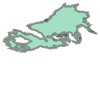

In [38]:
poly_ctx

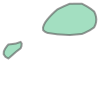

In [39]:
poly_svm

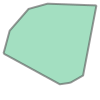

In [40]:
poly_ch

In [43]:
gdf_poly = gpd.GeoDataFrame(
    {"name": ["svm_ctx", "svm", "ch"]},
    geometry=[poly_ctx, poly_svm, poly_ch],
    crs="EPSG:4326"
)

gdf_train = gpd.GeoDataFrame(
    df_train.copy(),
    geometry=gpd.points_from_xy(df_train.longitude, df_train.latitude),
    crs="EPSG:4326"
)

m = KeplerGl(height=600)           # you can also pass width=...
m.add_data(data=gdf_train, name="TrainPoints")
m.add_data(data=gdf_poly,  name="Polygons")

# 3) (Optional) set the initial view near the polygon:
centroid = gdf.to_crs(4326).geometry.iloc[0].centroid
m.config = {
  "version": "v1",
  "config": {
    "mapState": {
      "latitude": centroid.y,
      "longitude": centroid.x,
      "zoom": 12,
      "pitch": 0,
      "bearing": 0
    }
  }
}

m  # display in the notebook

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


/home/tomf/.cache/pypoetry/virtualenvs/mobile-coverage-V9QxNgPA-py3.12/lib/python3.12/site-packages/jupyter_client/session.py:721: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant: nan
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)
/home/tomf/.cache/pypoetry/virtualenvs/mobile-coverage-V9QxNgPA-py3.12/lib/python3.12/site-packages/jupyter_client/session.py:721: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant: nan
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


KeplerGl(config={'version': 'v1', 'config': {'mapState': {'latitude': 52.76366271179916, 'longitude': -1.21037…

In [25]:
df['unique_cell'].value_counts()

unique_cell
b6b78eec6eb1e85d7b0de7fb49d12c4aadcd3b1b    179743
f117748b1c42637547c239987a174cfc31af8f61    129581
88177bc3f4230c4ff34ef191b4af0fbe0fea8501    111641
1504272b9c9f6f9ce18b20051de0393673646339    104376
1b6d62dd71f3b16b97d1524dc6161a0dff3873a7    100379
                                             ...  
b5121f71bf32b602f1b6fa1639d207047ba9ff55         1
40dc43540e2e29092d5beed149c81aa59fb72f28         1
34dd2a4a612a5ef014c074e94c6fc3399d78434a         1
1ded59fc821f745b11a73945b32dbe8abac0ed97         1
eea7e166f1818faef652ca222be95444872d3bc2         1
Name: count, Length: 31843, dtype: int64

In [ ]:
metric = 'f1'

my_best_convex_hull: Dict[Any, Tuple[float, BaseGeometry]] = {}
my_best_svm_hyperplanes: Dict[Any, Tuple[float, BaseGeometry]] = {}
my_best_svm_hyperplanes_ctx: Dict[Any, Tuple[float, BaseGeometry]] = {}

# optional: cache OSM layers per (cell_id, train_month) to avoid refetching
_osm_cache: Dict[Tuple[str, str], Tuple[gpd.GeoDataFrame, gpd.GeoDataFrame, gpd.GeoDataFrame]] = {}

# Select data for this cell only
df_cell = df[df['unique_cell'] == cell_id]
print("---")
print(f"Processing cell {cell_id}")

# Exclude last month
for month in all_months[:-2]:

    # Train/test split: month vs next month
    df_train = df_cell[(pd.to_datetime(df_cell['timestamp']).dt.to_period('M') == pd.to_datetime(month).to_period('M'))]
    test_month = (pd.to_datetime(month).to_period('M') + 1).strftime("%Y-%m-%d")

    # Guardrails: skip starved months
    if df_train.empty or len(df_train) < min_points_required:
        print(f"Skip {month}: not enough training points.")
        continue

    # Build bbox around train, with small margin
    lon_min, lon_max = df_train['longitude'].min(), df_train['longitude'].max()
    lat_min, lat_max = df_train['latitude'].min(), df_train['latitude'].max()
    lon_margin = (lon_max - lon_min) * 0.08 if (lon_max - lon_min) > 1e-9 else 0.01
    lat_margin = (lat_max - lat_min) * 0.08 if (lat_max - lat_min) > 1e-9 else 0.01
    lon_min -= lon_margin; lon_max += lon_margin
    lat_min -= lat_margin; lat_max += lat_margin

    df_test = df[
        (pd.to_datetime(df['timestamp']).dt.to_period('M') == pd.to_datetime(test_month).to_period('M')) &
        (df['longitude'] >= lon_min) & (df['longitude'] <= lon_max) &
        (df['latitude']  >= lat_min) & (df['latitude']  <= lat_max)
    ]

    if df_test.empty:
        print(f"Skip {month}: empty test set in bbox.")
        continue

    # Downsample test for performance (reproducible)
    n_test = int(len(df_test) * 0.25)
    if len(df_test) > n_test and n_test > 0:
        df_test = df_test.sample(n=n_test, random_state=42).reset_index(drop=True)

    print(f"---Training month: {month}, Testing month: {test_month}---")
    print(f"Train: {len(df_train)}, Test: {len(df_test)}")

    # Geometric baseline args
    convex_hull_args = {"quantile": 0.98}

    # Levels (cumulative)
    levels = {
        5: ["5. Very Strong"],
        4: ["4. Strong", "5. Very Strong"],
        3: ["3. Moderate", "4. Strong", "5. Very Strong"],
        2: ["2. Weak", "3. Moderate", "4. Strong", "5. Very Strong"],
        1: ["1. Very Weak", "2. Weak", "3. Moderate", "4. Strong", "5. Very Strong"],
    }

    # Build a coarse AOI hull for OSM context from train data
    full_ch = generate_convex_hull_geom(df_train, quantile=0.99)

    # Fetch OSM once per (cell, month)
    cache_key = (cell_id, str(pd.to_datetime(month).date()))
    if cache_key in _osm_cache:
        bldg_raw, roads_raw, aoi = _osm_cache[cache_key]
    else:
        bldg_raw, roads_raw, aoi = fetch_osm_by_hull(
            hull_geom=full_ch,
            hull_crs=4326,
            work_crs=27700,
            buffer_m=200.0,
            road_network_type="drive",
            road_simplify=True
        )
        _osm_cache[cache_key] = (bldg_raw, roads_raw, aoi)

    # Prep OSM layers, context pack and featurizer
    bldg, roads, aoi = prep_osm_layers(bldg_raw, roads_raw, aoi, work_crs=27700)
    ctx_pack     = build_context_pack(bldg, roads, radii_m=[100])  # tweak radii later
    featurizer   = make_featurizer(ctx_pack, max_edge_dist=500.0, batch=4000)
    feature_cols = ctx_pack["feature_cols"]

    # A tiny SVM grid for context features (use gamma='scale' when adding features)
    svm_ctx_grid = [
        {"kernel": "rbf", "nu": 0.02, "gamma": "scale"},
        {"kernel": "rbf", "nu": 0.04, "gamma": "scale"},
        {"kernel": "rbf", "nu": 0.06, "gamma": "scale"},
    ]

    # Vanilla SVM grid (lon/lat only)
    svm_grid = [
        {"kernel": "rbf", "nu": 0.02, "gamma": 3.0e4},
        {"kernel": "rbf", "nu": 0.02, "gamma": 2.0e4},
        {"kernel": "rbf", "nu": 0.02, "gamma": 1.0e4},
        {"kernel": "rbf", "nu": 0.04, "gamma": 3.0e4},
        {"kernel": "rbf", "nu": 0.04, "gamma": 2.0e4},
        {"kernel": "rbf", "nu": 0.04, "gamma": 1.0e4},
        {"kernel": "rbf", "nu": 0.06, "gamma": 3.0e4},
        {"kernel": "rbf", "nu": 0.06, "gamma": 2.0e4},
        {"kernel": "rbf", "nu": 0.06, "gamma": 1.0e4},
    ]

    # Iterate levels
    for key, level in levels.items():
        df_train_lvl = df_train[df_train["signal_level_category"].isin(level)]
        df_test_lvl  = df_test  # same test for both models

        # Project to BNG (meters)
        train_gdf = gpd.GeoDataFrame(df_train_lvl, geometry=gpd.points_from_xy(df_train_lvl.longitude, df_train_lvl.latitude), crs=4326)
        train_gdf = train_gdf.to_crs(27700)

        df_train_lvl["x_m"] = train_gdf.geometry.x
        df_train_lvl["y_m"] = train_gdf.geometry.y

        print(f"Level {key} {level}: train={len(df_train_lvl)} test={len(df_test_lvl)}")
        if len(df_train_lvl) < min_points_required:
            print(f"Skipping level {key}: insufficient train points.")
            continue

        # --- Convex hull baseline (level-specific) ---
        convex_hull = generate_convex_hull_geom(df_train_lvl, **convex_hull_args)
        y_true, y_pred_chull = eval_poly_on_frame(convex_hull, df_test_lvl, level, cell_id)
        metric_chull = get_classification_metric(y_true, y_pred_chull, metric)

        prev = my_best_convex_hull.get(key)
        if prev is None or metric_chull > prev[0]:
            my_best_convex_hull[key] = (metric_chull, convex_hull)

        # --- Vanilla SVM (lon/lat only) ---
        best_svm_tuple = my_best_svm_hyperplanes.get(key)
        for args in svm_grid:
            print(f"[SVM] Trying args: {args}")
            svm_poly = generate_svm_boundary_geom(df_train_lvl, x_col="x_m", y_col="y_m", **args)
            if svm_poly is None or svm_poly.is_empty:
                continue
            y_true, y_pred_svm = eval_poly_on_frame(svm_poly, df_test_lvl, level, cell_id)
            metric_svm = get_classification_metric(y_true, y_pred_svm, metric)
            if best_svm_tuple is None or metric_svm > best_svm_tuple[0]:
                best_svm_tuple = (metric_svm, svm_poly)
                my_best_svm_hyperplanes[key] = best_svm_tuple

        # --- Context SVM (geo features) ---
        # Build feature matrix for TRAIN only (context SVM trains in feature space)
        lonlat_train = df_train_lvl[["longitude", "latitude"]].to_numpy()
        X_train_ctx, _ = featurizer(lonlat_train)
        scaler_ctx = StandardScaler().fit(X_train_ctx)
        Xtr_ctx = scaler_ctx.transform(X_train_ctx)

        best_ctx_tuple = my_best_svm_hyperplanes_ctx.get(key)
        for ctx_args in svm_ctx_grid:
            print(f"[CTX] Trying args: {ctx_args}")
            clf_ctx = svm.OneClassSVM(**ctx_args).fit(Xtr_ctx)

            # Build the polygon over AOI using the SAME featurizer+scaler
            svm_ctx_poly = context_svm_boundary_polygon(
                aoi_gdf=aoi, featurizer=featurizer, scaler=scaler_ctx, clf=clf_ctx, resolution=300
            )
            if svm_ctx_poly is None or svm_ctx_poly.is_empty:
                continue

            # Evaluate against the exact test rows
            y_true, y_pred_ctx = eval_poly_on_frame(svm_ctx_poly, df_test_lvl, level, cell_id)
            metric_ctx = get_classification_metric(y_true, y_pred_ctx, metric)

            if best_ctx_tuple is None or metric_ctx > best_ctx_tuple[0]:
                best_ctx_tuple = (metric_ctx, svm_ctx_poly)
                my_best_svm_hyperplanes_ctx[key] = best_ctx_tuple


# ---------------------------
# Nesting: ensure higher levels are contained in lower ones
# ---------------------------
def ensure_overlapping_polygons(data: Dict[Any, Tuple[float, BaseGeometry]]
                                ) -> Dict[Any, Tuple[float, BaseGeometry]]:
    sorted_keys = sorted(data.keys(), reverse=True)  # 5 -> 1
    accumulated_geom = None
    filtered = {}
    for k in sorted_keys:
        m, g = data[k]
        if g is None or not g.is_valid:
            print(f"Skip level {k}: invalid geometry.")
            continue
        accumulated_geom = g if accumulated_geom is None else accumulated_geom.union(g)
        filtered[k] = (m, accumulated_geom)
    return dict(sorted(filtered.items()))  # back to ascending by key

my_best_convex_hull       = ensure_overlapping_polygons(my_best_convex_hull)
my_best_svm_hyperplanes   = ensure_overlapping_polygons(my_best_svm_hyperplanes)
my_best_svm_hyperplanes_ctx = ensure_overlapping_polygons(my_best_svm_hyperplanes_ctx)

# ---------------------------
# Metrics table
# ---------------------------
metrics_chull = [(k, my_best_convex_hull[k][0])       for k in my_best_convex_hull.keys()]
metrics_svm   = [(k, my_best_svm_hyperplanes[k][0])   for k in my_best_svm_hyperplanes.keys()]
metrics_ctx   = [(k, my_best_svm_hyperplanes_ctx[k][0]) for k in my_best_svm_hyperplanes_ctx.keys()]

metrics_df = (
    pd.DataFrame(metrics_chull, columns=['level', 'chull'])
      .merge(pd.DataFrame(metrics_svm, columns=['level', 'svm']), on='level', how='outer')
      .merge(pd.DataFrame(metrics_ctx, columns=['level', 'svm_ctx']), on='level', how='outer')
)


---
Processing cell 83c3d7642c3848655ad61f0ed3877799d3c75074
---Training month: 2025-03-01, Testing month: 2025-04-30---
Train: 2788, Test: 466758
Level 5 ['5. Very Strong']: train=56 test=466758
[SVM] Trying args: {'kernel': 'rbf', 'nu': 0.02, 'gamma': 30000.0}
[SVM] Trying args: {'kernel': 'rbf', 'nu': 0.02, 'gamma': 20000.0}
[SVM] Trying args: {'kernel': 'rbf', 'nu': 0.02, 'gamma': 10000.0}
[SVM] Trying args: {'kernel': 'rbf', 'nu': 0.04, 'gamma': 30000.0}
[SVM] Trying args: {'kernel': 'rbf', 'nu': 0.04, 'gamma': 20000.0}
[SVM] Trying args: {'kernel': 'rbf', 'nu': 0.04, 'gamma': 10000.0}
[SVM] Trying args: {'kernel': 'rbf', 'nu': 0.06, 'gamma': 30000.0}
[SVM] Trying args: {'kernel': 'rbf', 'nu': 0.06, 'gamma': 20000.0}
[SVM] Trying args: {'kernel': 'rbf', 'nu': 0.06, 'gamma': 10000.0}
[CTX] Trying args: {'kernel': 'rbf', 'nu': 0.02, 'gamma': 'scale'}
[CTX] Trying args: {'kernel': 'rbf', 'nu': 0.04, 'gamma': 'scale'}
[CTX] Trying args: {'kernel': 'rbf', 'nu': 0.06, 'gamma': 'scale'}


In [32]:
metrics_df

,level,chull,svm,svm_ctx
0,1,0.000332,0.001710,0.000409
1,2,0.000168,0.000545,0.000207
2,3,0.000000,0.000000,0.000000
3,4,0.000000,0.000000,0.000000
4,5,0.000000,0.000000,0.000000


In [35]:
my_geojson = {
    "type": "FeatureCollection",
    "features": []
}

# Append the best convex hulls to list
for key, value in my_best_convex_hull.items():
    my_geojson['features'].append({
        "type": "Feature",
        "properties": {
            "cell_id": cell_id,
            "levels": key,
            "model": "convex_hull",
            "fill": "#1100FF",
        },
        "geometry": shapely.geometry.mapping(value[1]),
    })

# Append the best SVM hyperplanes to list
for key, value in my_best_svm_hyperplanes.items():
    my_geojson['features'].append({
        "type": "Feature",
        "properties": {
            "cell_id": cell_id,
            "levels": key,
            "model": "svm",
            "fill": "#FF0000",
        },
        "geometry": shapely.geometry.mapping(value[1]),
    })

# Append the best SVM Context hyperplanes to list
for key, value in my_best_svm_hyperplanes_ctx.items():
    my_geojson['features'].append({
        "type": "Feature",
        "properties": {
            "cell_id": cell_id,
            "levels": key,
            "model": "svm_ctx",
            "fill": "#FF0000",
        },
        "geometry": shapely.geometry.mapping(value[1]),
    })

os.makedirs('cells', exist_ok=True)
with open(f"cells/cell_{cell_id}.geojson", "w") as f:
    json.dump(my_geojson, f, indent=2)

In [41]:
df_cell.to_csv('test_01.csv', index=False)

In [40]:
df_cell

,timestamp,unique_cell,measurement_type_name,in_outdoor_state,value,latitude,longitude,signal_level,signal_level_category
1090,2025-03-01 10:32:34.222,83c3d7642c3848655ad61f0ed3877799d3c75074,None,Probably Outdoor,5.0,52.774660,-1.138825,-101.484671,2. Weak
15925,2025-03-01 03:04:11.840,83c3d7642c3848655ad61f0ed3877799d3c75074,None,Probably Indoor,-11.0,52.783891,-1.241770,-107.241094,1. Very Weak
25898,2025-03-01 14:21:09.438,83c3d7642c3848655ad61f0ed3877799d3c75074,None,None,-11.0,52.782939,-1.241566,-110.815115,1. Very Weak
27254,2025-03-01 03:54:14.506,83c3d7642c3848655ad61f0ed3877799d3c75074,None,Probably Indoor,0.8,52.782791,-1.242043,-107.616618,1. Very Weak
34345,2025-03-01 03:23:35.705,83c3d7642c3848655ad61f0ed3877799d3c75074,None,Probably Indoor,-10.0,52.782972,-1.241619,-108.612224,1. Very Weak
...,...,...,...,...,...,...,...,...,...
8345818,2025-04-01 01:22:59.712,83c3d7642c3848655ad61f0ed3877799d3c75074,None,Probably Indoor,-106.0,52.782900,-1.241990,-82.984810,3. Moderate
8349748,2025-04-01 01:22:59.712,83c3d7642c3848655ad61f0ed3877799d3c75074,None,Probably Indoor,-0.4,52.782787,-1.241908,-94.405967,3. Moderate
8350128,2025-04-01 05:04:16.899,83c3d7642c3848655ad61f0ed3877799d3c75074,None,Probably Indoor,-102.0,52.783926,-1.241794,-110.397425,1. Very Weak
8353746,2025-04-01 08:22:16.000,83c3d7642c3848655ad61f0ed3877799d3c75074,None,Surely Outdoor,57.6,52.788246,-1.249296,-114.373256,1. Very Weak


In [29]:
df_test['signal_level_category'].value_counts(normalize=True)

signal_level_category
1. Very Weak      0.441556
2. Weak           0.314911
3. Moderate       0.185692
4. Strong         0.037567
5. Very Strong    0.020274
Name: proportion, dtype: float64

/tmp/ipykernel_313020/4071256093.py:4: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(); plt.show()


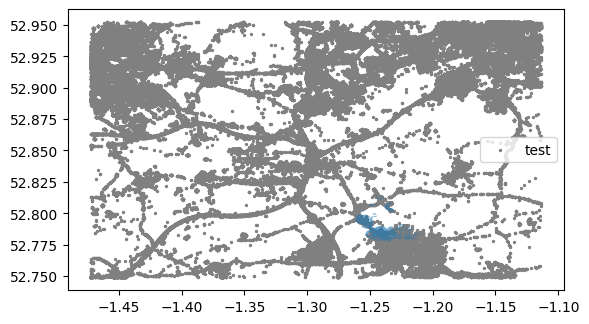

In [30]:
plt.scatter(df_test.longitude, df_test.latitude, s=2, c='gray', label='test')
for k, (_, g) in my_best_svm_hyperplanes_ctx.items():
    gpd.GeoSeries([g]).plot(ax=plt.gca(), alpha=0.2, label=f'ctx_{k}')
plt.legend(); plt.show()

In [31]:
covered = df_test.apply(lambda r: list(my_best_svm_hyperplanes_ctx.values())[0][1].contains(Point(r.longitude, r.latitude)), axis=1)
covered.mean()

np.float64(0.026339130770120706)

In [20]:
df_test

,timestamp,unique_cell,measurement_type_name,in_outdoor_state,value,latitude,longitude,signal_level,signal_level_category
0,2025-04-07 19:35:10.012,1e22a744a314032a52a36d4848d4f71a36a5a258,None,Probably Indoor,-111.000,52.871289,-1.299130,NaN,NaN
1,2025-04-14 16:34:33.773,a326a24b6c3c9be61c59eb2dd7bb97c66aee40bb,None,Probably Indoor,0.000,52.791221,-1.289248,-105.007060,1. Very Weak
2,2025-04-10 06:35:39.143,408787ba2b6f47394cbb33ab9cf6e9dd06a07977,None,None,38.000,52.885732,-1.303911,-119.397099,1. Very Weak
3,2025-04-01 17:06:14.969,7a7dcaf28471537740f1cfb9c2a6750529b4c445,None,Probably Outdoor,-12.000,52.910378,-1.476789,-115.542561,1. Very Weak
4,2025-04-08 12:07:11.008,285c3579d2c9766640f768174eed7ff02237cf20,None,Probably Indoor,4.692,52.927472,-1.423154,-120.000000,1. Very Weak
...,...,...,...,...,...,...,...,...,...
512858,2025-04-07 23:32:40.369,9ced79b196fcd2eb7dc4a37b1da6c0013b7ace71,None,Probably Indoor,-105.000,52.878284,-1.454059,-98.354083,2. Weak
512859,2025-04-03 15:50:11.431,4b848719435b29fdb3483543b54c9bfcc7eb51b4,None,Surely Indoor,9058.000,52.946526,-1.146888,-92.300992,3. Moderate
512860,2025-04-10 05:20:50.652,24677f6bcac8ad515b78bd67a141d4c9467e32cd,None,Probably Indoor,-15.000,52.858209,-1.389058,-96.250212,2. Weak
512861,2025-04-08 16:18:47.000,d4dd68361117da79f74634a00f2a2965a035291e,None,Surely Outdoor,39.600,52.924784,-1.469886,-109.509769,1. Very Weak


In [21]:
df_test.to_csv('df_test_sample_2.csv', index=False)

In [105]:
my_geojson = {
    "type": "FeatureCollection",
    "features": []
}

# Append the best convex hulls to list
for key, value in my_best_convex_hull.items():
    my_geojson['features'].append({
        "type": "Feature",
        "properties": {
            "cell_id": cell_id,
            "levels": key,
            "model": "convex_hull",
            "fill": "#1100FF",
        },
        "geometry": shapely.geometry.mapping(value[1]),
    })

# Append the best SVM hyperplanes to list
for key, value in my_best_svm_hyperplanes.items():
    my_geojson['features'].append({
        "type": "Feature",
        "properties": {
            "cell_id": cell_id,
            "levels": key,
            "model": "svm",
            "fill": "#FF0000",
        },
        "geometry": shapely.geometry.mapping(value[1]),
    })
    
# Export geojson for this cell
os.makedirs('cells', exist_ok=True)
with open(f"cells/cell_{cell_id}.geojson", "w") as f:
    json.dump(my_geojson, f, indent=2)

In [93]:
test_month

'2025-05-31'

In [92]:
len(df_test), len(df_train)

(307973, 70772)

In [ ]:
full_ch = generate_convex_hull_geom(df=df_filtered, quantile=0.99)

In [19]:
bldg, roads, aoi = fetch_osm_by_hull(
    hull_geom=full_ch,
    hull_crs=4326,     # change this if your hull isn’t WGS84
    work_crs=27700,    # BNG for metric buffers/areas
    buffer_m=200.0,    # expand AOI a little beyond hull
    # building_tags={"building": True, "amenity": ["school","hospital"]},  # optional
    road_network_type="drive",
    road_simplify=True
)

In [27]:
bldg, roads, aoi = prep_osm_layers(bldg, roads, aoi, work_crs=27700)

In [28]:
# choose radii
radii = [100]  # meters
ctx_pack = build_context_pack(bldg, roads, radii_m=radii)
featurizer = make_featurizer(ctx_pack, max_edge_dist=500.0, batch=5000)

feature_cols = ctx_pack["feature_cols"]  # keep for consistency everywhere

In [30]:
lonlat_train = df_filtered[["longitude","latitude"]].to_numpy()
X_train, feature_cols_ = featurizer(lonlat_train)   # feature order guaranteed

lonlat_test  = df_filtered[["longitude","latitude"]].to_numpy()
X_test,  _   = featurizer(lonlat_test)

In [33]:
scaler = StandardScaler().fit(X_train)
Xtr = scaler.transform(X_train)
Xte = scaler.transform(X_test)

clf = svm.OneClassSVM(kernel="rbf", nu=0.04, gamma="scale").fit(Xtr)

In [34]:
# Build lon/lat grid over AOI bbox (work in WGS84, then featurize)
aoi_wgs = aoi.to_crs(4326)
minx, miny, maxx, maxy = aoi_wgs.total_bounds
res = 300  # start modest
gx, gy = np.meshgrid(np.linspace(minx, maxx, res), np.linspace(miny, maxy, res))
grid_lonlat = np.c_[gx.ravel(), gy.ravel()]

# Featurize grid with SAME featurizer+scaler
Xg, _ = featurizer(grid_lonlat)
Xg = scaler.transform(Xg)

# Score and contour at 0 to extract the learned boundary
Z = clf.decision_function(Xg).reshape(gx.shape)

fig, ax = plt.subplots()
cs = ax.contour(gx, gy, Z, levels=[0])  # in lon/lat
plt.close(fig)

lines = [LineString(seg) for seg in cs.allsegs[0] if len(seg) >= 2]
polys = list(polygonize(lines))
svm_poly = unary_union(polys).buffer(0)  # clean geometry

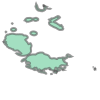

In [35]:
svm_poly

In [13]:
# Identify cells already processed in folder
processed_cells = [re.search(r"cell_([a-zA-Z0-9]*)_metrics.csv", f).group(1) for f in os.listdir("cells") if re.match(r"cell_[a-zA-Z0-9]*_metrics.csv", f)]

# Remove those already processed
sufficient_data_cells = [cell for cell in sufficient_data_cells if cell not in processed_cells]

# allowed_cells = ["5a6685a51c70f12cc7b03db00a18db684e60835c"]

# Take the top X cells for processing
allowed_cells = sufficient_data_cells[0:300]

In [14]:
len(sufficient_data_cells)

2866

In [15]:
df = df[df['unique_cell'].isin(allowed_cells)]

In [16]:
df['unique_cell'].value_counts()

unique_cell
fe4659b3f3f9f82090f7d4a5463804cdd1840293    4916
83c3d7642c3848655ad61f0ed3877799d3c75074    2810
074f074de511b5bdd5e0f0e631af83ed06e00a89    1264
81e7643763e6400cf45747ae5fbb1b3f60331803    1193
ff0e3eddded9a78ee2418f0bfe8eb9e82fdefaa9     834
                                            ... 
9c68ed8ad03d6ddadea04b9209f0f99017866f76      33
c74c5f1c4acdbf553b8ce73114c10fada16d4527      33
d25dd765cc93a82934c63856024743003a789022      33
aacab4fc0e54cb4da7546a4eed4473fecc65ee32      32
7a14ec5cf928c29dcbf169523a61181eee7fec28      31
Name: count, Length: 300, dtype: int64

In [39]:
ch = generate_convex_hull_geom(df=df_filtered, quantile=0.95)

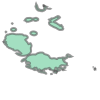

In [38]:
svm_poly

In [41]:
svm_old = generate_svm_boundary_geom(df=df_filtered, kernel='rbf', nu=0.08, gamma=30000)

In [40]:
my_geojson = {
    "type": "FeatureCollection",
    "features": []
}

In [44]:
my_geojson['features'].append({
    "type": "Feature",
    "properties": {
        "model": "svm_context",
        "fill": "#13DD2E",
    },
    "geometry": shapely.geometry.mapping(svm_poly),
})

In [45]:
with open("test_01.geojson", "w") as f:
    json.dump(my_geojson, f, indent=2)